In [1]:
import os
from os import path 
from time import time

import jax
import jax.numpy as jnp
import numpy as np 

import numpy as np 

from astropy import units as u
from astropy import constants as const 

from functools import partial

In [2]:
# test to see what device we are running on 
try: 
    from jax.lib import xla_bridge
    print(xla_bridge.get_backend().platform)
except: 
    print(xla_bridge.get_backend().platform)

cpu


2024-06-12 12:59:08.049369: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.size'] = 12
plt.rcParams["xtick.top"] = True
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["xtick.minor.size"] = 4.5
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["ytick.minor.size"] = 4.5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams.update({"text.usetex": True})

In [4]:
import peytonites
from peytonites import (
    Distribution, SimState,
    kpc_to_cm, cm_to_kpc, 
    lyr_to_cm, cm_to_lyr, 
    au_to_cm, cm_to_au
)

# Load Inital Condition

In [5]:
sim_init_cond = SimState.read('init_conds/solar_system_100000step_init.dat')

# Traditional Simulation

In [6]:
def traditional_simulation(sim_init_cond, out_dir, verbose=True):
    
    G = sim_init_cond.G # cm^3 / (g s^2)
    dt = sim_init_cond.dt
    nsteps = sim_init_cond.nsteps
    out_interval = sim_init_cond.out_interval
    soft = sim_init_cond.soft
    
    init_dist = sim_init_cond.distribution
    
    number_particles = init_dist.N
    
    x_arr = init_dist.x.copy()
    y_arr = init_dist.y.copy()
    z_arr = init_dist.z.copy()
    
    vx_arr = init_dist.vx.copy()
    vy_arr = init_dist.vy.copy()
    vz_arr = init_dist.vz.copy()
    
    mass_arr = init_dist.m.copy()
    #----------------------------------------
    for step in range(nsteps): 
        ax_arr = np.zeros_like(x_arr)
        ay_arr = np.zeros_like(x_arr)
        az_arr = np.zeros_like(x_arr)

        for i in range(number_particles):
            ax, ay, az = 0., 0., 0.
            xi, yi, zi = x_arr[i], y_arr[i], z_arr[i]

            for j in range(number_particles):
                if i == j:
                    continue

                dx = xi - x_arr[j]
                dy = yi - y_arr[j]
                dz = zi - z_arr[j]

                r_ij_squared = dx**2 + dy**2 + dz**2 + soft**2
                r_ij = np.sqrt(r_ij_squared)
                r_ij_cubed = r_ij_squared * r_ij

                mj = mass_arr[j]
                a = - (G * mj) / r_ij_cubed

                ax += a * dx 
                ay += a * dy 
                az += a * dz 

            ax_arr[i] = ax 
            ay_arr[i] = ay
            az_arr[i] = az

        
        for i in range(number_particles):

            vx_arr[i] += ax_arr[i] * dt
            vy_arr[i] += ay_arr[i] * dt
            vz_arr[i] += az_arr[i] * dt


            x_arr[i] += vx_arr[i] * dt
            y_arr[i] += vy_arr[i] * dt
            z_arr[i] += vz_arr[i] * dt
    #----------------------------------------

        if step % out_interval == 0:
            if verbose:
                print(step)
            
            step_params = sim_init_cond.copy()
            if step > 0:
                step_dist = Distribution.from_arrays(
                    x_arr, y_arr, z_arr, 
                    vx_arr, vy_arr, vz_arr,
                    mass_arr, name=init_dist.name)

                step_params = sim_init_cond.copy()
                step_params.distribution = step_dist                
            
            step_filename = 'step_{:08d}.dat'.format(step)
            step_path = path.join(out_dir, step_filename)
            
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            
            step_params.write(step_path)
            
    if verbose:
        print(step)
    return 
    

### Define Output Dir

Make sure to have a `simout` in the name for git ignore

In [7]:
out_dir = './solar_system_simout'

In [8]:
tstart = time()
traditional_simulation(sim_init_cond, out_dir, verbose=False)
tend = time()

traditional_run_time = (tend-tstart)*u.s
print('done', 'traditional_run_time:', traditional_run_time)

done traditional_run_time: 19.01957869529724 s


# Vector Simulation

**Running this will replace/overwrite the last outputs**

Using vectorized operations in this implementation significantly reduces computation time compared to the double for-loop, but at the cost of massively increased memory usage due to storing large intermediate arrays for pairwise distances and accelerations.



In [9]:
def vector_simulation(n_steps, sim_init_cond, out_dir, verbose=False):
    
    G = sim_init_cond.G # cm^3 / (g s^2)
    dt = sim_init_cond.dt
    nsteps = n_steps #sim_init_cond.nsteps
    out_interval = sim_init_cond.out_interval
    soft = sim_init_cond.soft
    
    init_dist = sim_init_cond.distribution
    
    number_particles = init_dist.N
    
    x_arr = init_dist.x.copy()
    y_arr = init_dist.y.copy()
    z_arr = init_dist.z.copy()
    
    vx_arr = init_dist.vx.copy()
    vy_arr = init_dist.vy.copy()
    vz_arr = init_dist.vz.copy()
    
    mass_arr = init_dist.m.copy()
    #----------------------------------------
    for step in range(nsteps): 
        dx = x_arr[:, np.newaxis] - x_arr
        dy = y_arr[:, np.newaxis] - y_arr
        dz = z_arr[:, np.newaxis] - z_arr
        
        # Avoid division by zero by adding softening length
        r_squared = dx**2 + dy**2 + dz**2 + soft**2
        np.fill_diagonal(r_squared, 1)  # Avoid self-interaction
        
        r = np.sqrt(r_squared)
        r_cubed = r_squared * r
        
        # Compute accelerations
        a = -G * mass_arr / r_cubed
        np.fill_diagonal(a, 0)  
        ax_arr = np.sum(a * dx, axis=1)
        ay_arr = np.sum(a * dy, axis=1)
        az_arr = np.sum(a * dz, axis=1)
        
        
        # Update velocities and positions
        vx_arr += ax_arr * dt
        vy_arr += ay_arr * dt
        vz_arr += az_arr * dt
        
        x_arr += vx_arr * dt
        y_arr += vy_arr * dt
        z_arr += vz_arr * dt
    #----------------------------------------

        if step % out_interval == 0:
            if verbose:
                print(step) 
            
            step_params = sim_init_cond.copy()
            if step > 0:
                step_dist = Distribution.from_arrays(
                    x_arr, y_arr, z_arr, 
                    vx_arr, vy_arr, vz_arr,
                    mass_arr, name=init_dist.name)

                step_params = sim_init_cond.copy()
                step_params.distribution = step_dist                
            
            step_filename = 'step_{:08d}.dat'.format(step)
            step_path = path.join(out_dir, step_filename)
            
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            
            step_params.write(step_path)
    if verbose:
        print(step) 
    #----------------------------------------
    return 
    

In [10]:
@jax.jit
def body(x_arr, 
        y_arr, 
        z_arr, 
        mass_arr,
        vx_arr, 
        vy_arr,
        vz_arr,
        G,
        dt):
    
    dx = x_arr[:, jnp.newaxis] - x_arr
    dy = y_arr[:, jnp.newaxis] - y_arr
    dz = z_arr[:, jnp.newaxis] - z_arr
        
    # Avoid division by zero by adding softening length
    r_squared = dx**2 + dy**2 + dz**2 + soft**2
    jnp.fill_diagonal(r_squared, 1, inplace=False)  # Avoid self-interaction
        
    r = jnp.sqrt(r_squared)
    r_cubed = r_squared * r
        
    # Compute accelerations
    a = -G * mass_arr / r_cubed
    jnp.fill_diagonal(a, 0, inplace=False)  
    ax_arr = jnp.sum(a * dx, axis=1)
    ay_arr = jnp.sum(a * dy, axis=1)
    az_arr = jnp.sum(a * dz, axis=1)
        
        
    # Update velocities and positions
    vx_arr += ax_arr * dt
    vy_arr += ay_arr * dt
    vz_arr += az_arr * dt
        
    x_arr += vx_arr * dt
    y_arr += vy_arr * dt
    z_arr += vz_arr * dt
    #----------------------------------------
        
    return x_arr, y_arr, z_arr, mass_arr,vx_arr, vy_arr,vz_arr,G,dt


def jax_simulation(n_steps, sim_init_cond, out_dir, verbose=False):
    
    G = sim_init_cond.G # cm^3 / (g s^2)
    dt = sim_init_cond.dt
    nsteps = n_steps  #sim_init_cond.nsteps
    out_interval = sim_init_cond.out_interval
    soft = sim_init_cond.soft
    
    init_dist = sim_init_cond.distribution
    
    number_particles = init_dist.N
    
    x_arr = jnp.array(init_dist.x.copy())
    y_arr = jnp.array(init_dist.y.copy())
    z_arr = jnp.array(init_dist.z.copy())
    
    vx_arr = jnp.array(init_dist.vx.copy())
    vy_arr = jnp.array(init_dist.vy.copy())
    vz_arr = jnp.array(init_dist.vz.copy())
    
    mass_arr = jnp.array(init_dist.m.copy())
    #----------------------------------------
    for step in range(nsteps): 
        x_arr, y_arr, z_arr, mass_arr,vx_arr, vy_arr,vz_arr,G,dt = body(x_arr, 
        y_arr, 
        z_arr, 
        mass_arr,
        vx_arr, 
        vy_arr,
        vz_arr,
        G,
        dt)
        
        if step % out_interval == 0:
            
            step_params = sim_init_cond.copy()
            if step > 0:
                step_dist = Distribution.from_arrays(
                    np.array(x_arr), np.array(y_arr), np.array(z_arr), 
                    np.array(vx_arr), np.array(vy_arr), np.array(vz_arr),
                    np.array(mass_arr), name=init_dist.name)

                step_params = sim_init_cond.copy()
                step_params.distribution = step_dist                
            
            step_filename = 'step_{:08d}.dat'.format(step)
            step_path = path.join(out_dir, step_filename)
            
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            
            step_params.write(step_path)

    return 

Points: 5000, Distribution: Plummer
Points: 5000, Distribution: Plummer
Points: 10000, Distribution: Plummer+Plummer


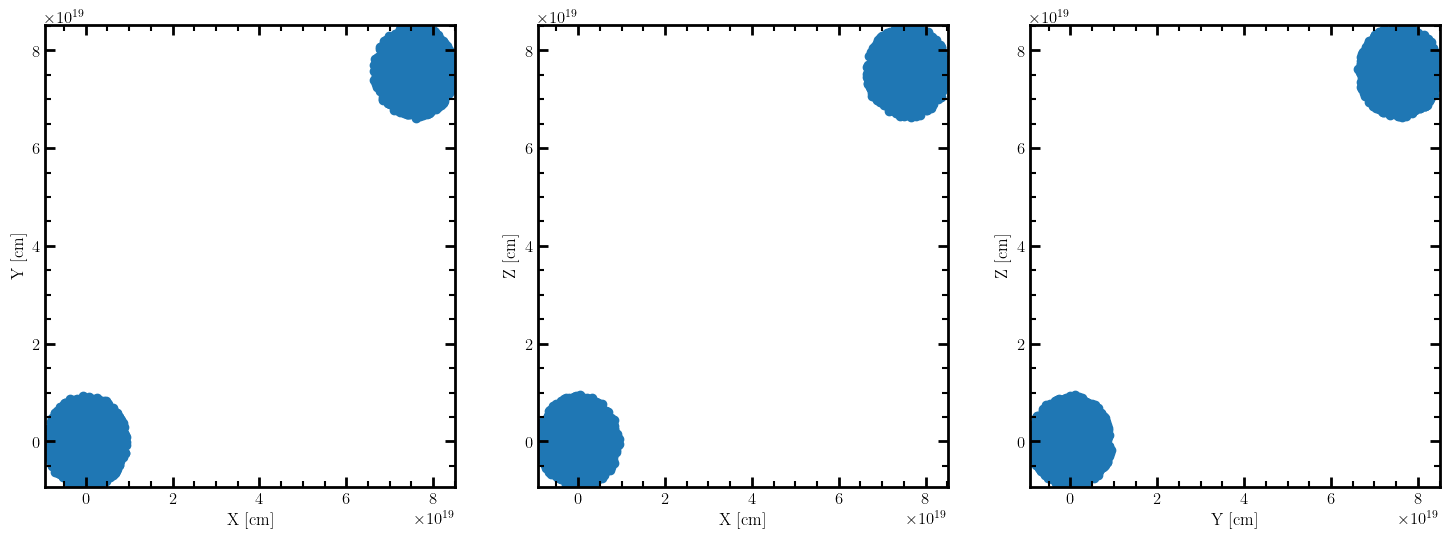

done


In [11]:
N = 10000
total_mass = N * (1*u.M_sun).to('g').value
radius = (10*u.lyr).to('cm').value
dynamical_time = peytonites.dynamical_time(total_mass, radius)

dist_1 = peytonites.plummer(
    N // 2, radius,
    x0=0, y0=0, z0=0,
    total_mass=total_mass,
    vx0=0.0, vy0=0.0, vz0=0.0,
    max_radius=radius
)

dist_2 = peytonites.plummer(
    N // 2, radius,
    x0=radius*8, y0=radius*8, z0=radius*8,
    total_mass=total_mass,
    vx0=0.0, vy0=0.0, vz0=0.0,
    max_radius=radius
)


dist_combo = dist_1 + dist_2

print(dist_1)
print(dist_2)
print(dist_combo)

dist_combo.plot()
plt.show()

# Estimate softening param based on number density and mean length:
soft = peytonites.estimate_softening_length(N, radius, fraction=0.5)

sim_init_cond = SimState(
    distribution=dist_combo, # `Distribution` object
    nsteps=10000, # Number of steps in the sim
    dt=dynamical_time / 100, # Time interval for each time-step
    soft=soft, # Softening parameter
    out_interval=10 # Output sim every out_interval
)

print('done')

In [ ]:
out_dir = './solar_system_simout_JAX'
#sim_init_cond = SimState.read('init_conds/plummer_collision_10000p_10000step_init.dat')
jitted_sim = jax.jit(jax_simulation, static_argnums=(0,1,2,3))
steps = 100

# ------------------------------------------ #
# ------------------------------------------ #
print('            timing tests')
print('------------------------------------')
print('            vectorized')
tstart = time()
vector_simulation(steps, sim_init_cond, out_dir)
tend = time()

vector_run_time = (tend-tstart)*u.s
print('done', 'vector_run_time', vector_run_time)

# ------------------------------------------ #
# ------------------------------------------ #
print('           JIT compiled')
tstart = time()
jax_simulation(steps, sim_init_cond, out_dir, verbose=False)
tend = time()

vector_run_time = (tend-tstart)*u.s
print('done', 'jax compile_and_run_time', vector_run_time)

            timing tests
------------------------------------
            vectorized


# Visualization

### By "Hand"

In [ ]:
file_path = path.join(out_dir, 'step_00000090.dat')

# Load simulation state
step_state = SimState.read(file_path)

# Get particle distribution 
dist = step_state.distribution

# Plot x and y in cm 
plt.scatter(dist.x, dist.y)
plt.title('Quick Plot')
plt.show()

# Plot x and y in AU 
# (you can also use astropy units) 
plt.scatter(cm_to_au(dist.x), cm_to_au(dist.y), c='k')

# Make the sun a star
plt.scatter(cm_to_au(dist.x[0]), cm_to_au(dist.y[0]), 
            marker='*', c='orange', s=100, label='sun')

plt.xlim(-38, 38)
plt.ylim(-38, 38)
plt.title('Solar System in AU')
plt.legend()

plt.show()

### 2D GIF

This gif will be saved in the `out_dir`. Its kind of slow but does the job! 

In [ ]:
peytonites.simulation_to_gif_2d(
    out_dir, 
    gif_filename='solar_sys_2d.gif', 
    extent=1e7*u.AU, 
    unit='AU'
)

### 3D GIF

This gif will be saved in the `out_dir`. Its kind of slow but does the job! 

In [ ]:
peytonites.simulation_to_gif_3d(out_dir, gif_filename='solar_sys_3d.gif', extent=1e7*u.AU, unit='AU')